First portion of notebook (synthetic data and  EM) are from
[Scott's latest Gaussian HMM notebook](https://github.com/probml/ssm-jax/blob/scott/notebooks/gaussian_hmm.ipynb).

Note that I am also using `probml/ssm-jax` implementation as opposed to `lindermanlab/ssm-jax`
because the notation/calls seem less clunky, and the backward sampling code is implemented here.

In [39]:
import jax.numpy as jnp
import jax.random as jr
from jax import jit

# from ssm.hmm.models import GaussianHMM                                        # lindermanlab/ssm-jax: https://github.com/lindermanlab/ssm-jax
from ssm_jax.hmm.models import GaussianHMM                                      # probml/ssm-jax : https://github.com/probml/ssm-jax
from ssm_jax.hmm.inference import HMMPosterior

from tqdm.auto import trange

In [3]:
# Used to silence tfp warnings: "WARNING:root:The use of `check_types`` is deprecated and does not have any effect."
# Source: https://github.com/tensorflow/probability/issues/1523

import logging
logger = logging.getLogger("root")
# logger = logging.getLogger()

# Suppress WARNING messages. only allow CRITICAL or ERROR messages to pass through
# See doc: https://docs.python.org/3/library/logging.html#levels
logger.setLevel(40)

In [4]:
def one_hot(arr, n_states):
    return jnp.eye(n_states)[arr]

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "clay",
    "pink",
    "greyish",
    "mint",
    "light cyan",
    "steel blue",
    "forest green",
    "pastel purple",
    "salmon",
    "dark brown"]

colors = sns.xkcd_palette(color_names)

def white_to_color_cmap(color, nsteps=256):
    """Return a cmap which ranges from white to the specified color.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    """
    # Get a red-white-black cmap
    cdict = {'red': ((0.0, 1.0, 1.0),
                       (1.0, color[0], color[0])),
                'green': ((0.0, 1.0, 1.0),
                          (1.0, color[1], color[0])),
                'blue': ((0.0, 1.0, 1.0),
                         (1.0, color[2], color[0]))}
    cmap = LinearSegmentedColormap('white_color_colormap', cdict, nsteps)
    return cmap


def gradient_cmap(colors, nsteps=256, bounds=None):
    """Return a colormap that interpolates between a set of colors.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    """
    ncolors = len(colors)
    # assert colors.shape[1] == 3
    if bounds is None:
        bounds = jnp.linspace(0,1,ncolors)


    reds = []
    greens = []
    blues = []
    alphas = []
    for b,c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1., 1.))

    cdict = {'red': tuple(reds),
             'green': tuple(greens),
             'blue': tuple(blues),
             'alpha': tuple(alphas)}

    cmap = LinearSegmentedColormap('grad_colormap', cdict, nsteps)
    return cmap

cmap = gradient_cmap(colors)

# Construct an HMM with Gaussian observations

The generative model is given by

\begin{align*}
z_1 &\sim \textrm{Cat}(\pi) \\
z_{t} \mid z_{t-1} &\sim \textrm{Cat}(P_{z_{t-1}})
    &&\textrm{for } t=2,\ldots,T\\
x_{t} \mid z_t &\sim \mathcal{N}(\mu_{z_t}, \Sigma_{z_t})
    &&\textrm{for } t=1,\ldots,T
\end{align*}

for initial state probabilities $\pi \in \Delta^K$,
transition matrix $P\in\mathbb{R}^{K\times K}$ whose rows sum to 1,
state means $\{\mu\in\mathbb{R}^{D}\}_{k=1}^K$, and
state covariances $\{\Sigma\in\mathbb{S}^{D}\}_{k=1}^K$.

$K$ is the number of latent states in the HMM and
$D$ is the emissions dimension.

In [6]:
# Set dimensions
num_states = 5
emission_dim = 2

# Specify parameters of the HMM
initial_state_probs = jnp.ones(num_states) / num_states
transition_matrix = 0.95 * jnp.eye(num_states) + 0.05 * jnp.roll(jnp.eye(num_states), 1, axis=1)
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, num_states+1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, num_states+1))[:-1]
])
emission_covs = jnp.tile(0.1**2 * jnp.eye(emission_dim), (num_states, 1, 1))

# Make a true HMM
true_hmm = GaussianHMM(initial_state_probs,
                       transition_matrix,
                       emission_means, 
                       emission_covs)

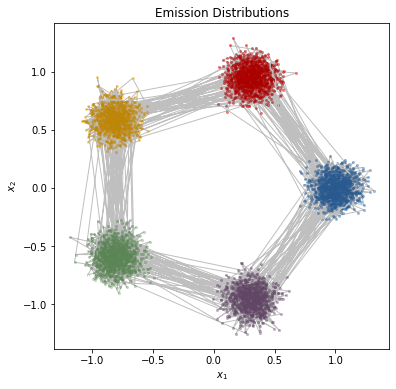

In [7]:
num_timesteps = 5000
true_states, emissions = true_hmm.sample(jr.PRNGKey(0), num_timesteps)

def plot_gaussian_hmm(hmm, emissions, states):
    lim = .85 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), 
                          jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    lls = hmm.emission_distribution.log_prob(grid[:, None, :])
    plt.figure(figsize=(6, 6))
    for k in range(hmm.num_states):
        # True distributions (difficult to see)
        plt.contour(XX, YY, jnp.exp(lls[:,k]).reshape(XX.shape),
                    cmap=white_to_color_cmap(colors[k]))
        
        # Observations
        plt.plot(emissions[states==k, 0], 
                 emissions[states==k, 1], 
                 'o', mfc=colors[k], mec='none', ms=3, 
                 alpha=.5)

    # Transitions between observations
    plt.plot(emissions[:,0], emissions[:,1], '-k', lw=1, alpha=.25)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Emission Distributions")
    
plot_gaussian_hmm(true_hmm, emissions, true_states)


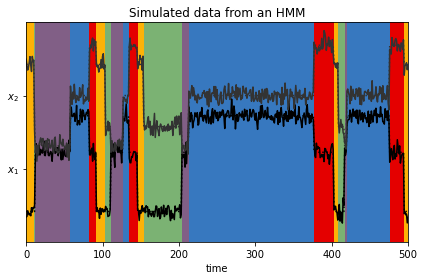

In [8]:
def plot_gaussian_hmm_emissions(hmm, emissions, states, xlim=None):
    # Plot the data and the smoothed data
    lim = 1.05 * abs(emissions).max()
    plt.imshow(states[None,:],
               aspect="auto",
               interpolation="none",
               cmap=cmap,
               vmin=0, vmax=len(colors)-1,
               extent=(0, num_timesteps, -lim, (emission_dim)*lim),
               alpha=1)

    means = true_hmm.emission_means[states]
    d_colors = ['k', '0.2']
    for d in range(emission_dim):
        # True means (difficult to see)
        plt.plot(means[:,d] + lim * d, ':', color=d_colors[d])

        # Observations
        plt.plot(emissions[:,d] + lim * d, '-', color=d_colors[d])
        

    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)
        
    plt.xlabel("time")
    plt.yticks(lim * jnp.arange(emission_dim), ["$x_{}$".format(d+1) for d in range(emission_dim)])
    
    plt.title("Simulated data from an HMM")
    plt.tight_layout()
    
plot_gaussian_hmm_emissions(true_hmm, emissions, true_states, xlim=(0, 500))

In [9]:
print("log joint prob:    ", true_hmm.log_prob(true_states, emissions)/len(emissions))
print("log marginal prob: ", true_hmm.marginal_log_prob(emissions)/len(emissions))

log joint prob:     1.5816416
log marginal prob:  1.5816412


# Batch EM

In [10]:
from ssm_jax.hmm.inference import hmm_smoother
from tensorflow_probability.substrates.jax.distributions import Dirichlet

# Initialize a random GaussianHMM
test_hmm = GaussianHMM.random_initialization(jr.PRNGKey(1), num_states, emission_dim)

# Define the EM steps
def e_step(hmm, emissions):
    return hmm_smoother(hmm.initial_probabilities,
                        hmm.transition_matrix,
                        hmm.emission_distribution.log_prob(emissions[..., None, :]))

def m_step(emissions, posterior):
    # Initial distribution
    initial_probs = Dirichlet(1.0001 + posterior.smoothed_probs[0]).mode()

    # Transition distribution
    transition_matrix = Dirichlet(
        1.0001 + jnp.einsum('tij->ij', posterior.smoothed_transition_probs)).mode()

    # Gaussian emission distribution
    w_sum = jnp.einsum('tk->k', posterior.smoothed_probs)
    x_sum = jnp.einsum('tk, ti->ki', posterior.smoothed_probs, emissions)
    xxT_sum = jnp.einsum('tk, ti, tj->kij', posterior.smoothed_probs, emissions, emissions)

    emission_means = x_sum / w_sum[:, None]
    emission_covs = xxT_sum / w_sum[:, None, None] \
        - jnp.einsum('ki,kj->kij', emission_means, emission_means) \
        + 1e-4 * jnp.eye(emissions.shape[1])
    
    # Pack the results into a new GaussianHMM
    return GaussianHMM(initial_probs,
                       transition_matrix,
                       emission_means,
                       emission_covs)

@jit
def em_step(hmm):
    posterior = e_step(hmm, emissions)
    hmm = m_step(emissions, posterior)
    return hmm, posterior

# Run the EM iterations
log_probs = []
for _ in trange(50):
    test_hmm, posterior = em_step(test_hmm)
    log_probs.append(posterior.marginal_log_lkhd)

  0%|          | 0/50 [00:00<?, ?it/s]

true LL:  1.5816412
infd LL:  0.93226767


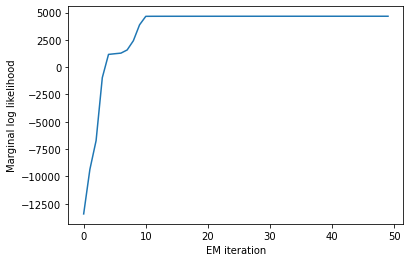

In [11]:
# Log probabilities vs. EM iterations
plt.plot(log_probs)
plt.xlabel("EM iteration")
plt.ylabel("Marginal log likelihood")

# True vs. inferred log-likelihood
print("true LL: ", true_hmm.marginal_log_prob(emissions)/len(emissions))
print("infd LL: ", test_hmm.marginal_log_prob(emissions)/len(emissions))

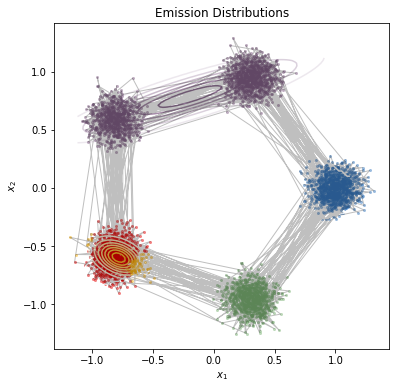

In [12]:
most_likely_states = test_hmm.most_likely_states(emissions)
plot_gaussian_hmm(test_hmm, emissions, most_likely_states)

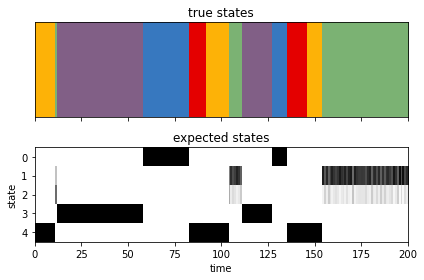

In [13]:
# TODO: Ideally, make white background in expected states transparent
# Then, display true states (in color) with black ticks of expected states on top
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(true_states[None,:],
              aspect="auto",
              interpolation="none",
              cmap=cmap, 
              vmin=0, vmax=len(colors)-1,
              alpha=1)
axs[0].set_yticks([])
axs[0].set_title("true states")

axs[1].imshow(posterior.smoothed_probs.T,
              aspect="auto",
              interpolation="none",
              cmap="Greys",
              vmin=0, vmax=1)
axs[1].set_yticks(jnp.arange(test_hmm.num_states))
axs[1].set_ylabel("state")
axs[1].set_xlabel("time")
axs[1].set_title("expected states")

plt.xlim(0, 200)
plt.tight_layout()

# Stochastic EM

In [23]:
def m_step_minibatch(emissions: jnp.ndarray,
                     posterior: HMMPosterior,
                     total_num_emissions: int,
                     rolling_stats: tuple,
                     step_size: float):
    """Roll information from new minibatch of data into HMM and sufficient statistics.

    Returns
        hmm: GaussianHMM
        new_rolling_stats: tuple
    """

    # Initial distribution
    initial_probs = Dirichlet(1.0001 + posterior.smoothed_probs[0]).mode()

    # Transition distribution
    transition_matrix = Dirichlet(
        1.0001 + jnp.einsum('tij->ij', posterior.smoothed_transition_probs)).mode()

    # -------------------------------------------------------------------------
    # Gaussian sufficient statistics, weighted by expected states
    w_sum = jnp.einsum('tk->k', posterior.smoothed_probs)
    x_sum = jnp.einsum('tk, ti->ki', posterior.smoothed_probs, emissions)
    xxT_sum = jnp.einsum('tk, ti, tj->kij', posterior.smoothed_probs, emissions, emissions)

    # Rescale by relative batch size and roll into previous sufficient statistics
    rescale = total_num_emissions / len(emissions)
    new_rolling_stats = w_sum, x_sum, xxT_sum = \
            tuple((1-step_size)*ss_prev + step_size*rescale*ss
            for ss_prev, ss in zip(rolling_stats, (w_sum, x_sum, xxT_sum)))
    
    # Calculate standard statistics
    emission_means = x_sum / w_sum[:, None]
    emission_covs = xxT_sum / w_sum[:, None, None] \
        - jnp.einsum('ki,kj->kij', emission_means, emission_means) \
        + 1e-4 * jnp.eye(emissions.shape[1])
    
    # Pack the standard results into a new GaussianHMM, return tuple of weighted sufficient statistics
    return GaussianHMM(initial_probs,
                       transition_matrix,
                       emission_means,
                       emission_covs), \
           new_rolling_stats  

In [34]:
def posterior_random_initialization(key, emissions, num_states):
    num_emissions = len(emissions)
    expected_states = jr.uniform(key, (num_emissions, num_states,))
    expected_states /= expected_states.sum(axis=1, keepdims=True)
    posterior = HMMPosterior(marginal_log_lkhd=-jnp.inf,
                        filtered_probs=None,
                        smoothed_probs=expected_states,
                        smoothed_transition_probs=None,)

    # Gaussian sufficient statistics, weighted by expected states
    w_sum = jnp.einsum('tk->k', posterior.smoothed_probs)
    x_sum = jnp.einsum('tk, ti->ki', posterior.smoothed_probs, emissions)
    xxT_sum = jnp.einsum('tk, ti, tj->kij', posterior.smoothed_probs, emissions, emissions)

    return posterior, (w_sum, x_sum, xxT_sum)


def hmm_stochastic_em(seed: jr.PRNGKey,
                      train_dataset: list[jnp.ndarray],
                      validation_dataset: jnp.ndarray,
                      hmm,
                      num_epochs: int=10,
                      ):

    num_batches = len(train_dataset)
    num_train = sum(len(train_m) for train_m in train_dataset)
    num_validation = len(validation_dataset)
    
    # Initialize the step size schedule
    schedule = jnp.arange(1, 1 + num_batches * num_epochs)**(-0.5)

    # Initialize progress bars
    outer_pbar = trange(num_epochs)
    inner_pbar = trange(num_batches)
    outer_pbar.set_description("Epoch")
    inner_pbar.set_description("Batch")

    # Initialize with a random posterior on the first batch
    seed, seed_init = jr.split(seed)
    posterior, rolling_stats = posterior_random_initialization(seed_init, train_dataset[0], hmm.num_states)

    train_lls = []
    validation_lls = []
    for epoch in range(num_epochs):
        seed_e = jr.fold_in(seed, epoch)
        perm = jr.permutation(seed_e, num_batches)

        inner_pbar.reset()
        for m in range(num_batches):
            # Extract minibatch
            train_m = train_dataset[perm[m]]
            num_minibatch = len(train_m)

            # E-step for minibatch
            posterior = e_step(hmm, train_m)

            # M step
            step_size = schedule[epoch * num_batches + m]
            hmm, rolling_stats = m_step_minibatch(
                     train_m, posterior, num_train, rolling_stats, step_size)
            
            # Store normalized log-likelihood for minibatch
            avg_train_mll = posterior.marginal_log_lkhd / num_minibatch
            train_lls.append(avg_train_mll)
            inner_pbar.set_description("Batch LL: {:.3f}".format(avg_train_mll))
            inner_pbar.update()


        # Evaluate likelihood and posteriors on validation dataset
        validation_posterior = e_step(hmm, validation_dataset)
        avg_validation_mll = validation_posterior.marginal_log_lkhd / num_validation
        validation_lls.append(avg_validation_mll)

        outer_pbar.set_description("validation LL: {:.3f}".format(avg_validation_mll))
        outer_pbar.update()
    
    # Finally, compute the posteriors for each training dataset
    print("Computing posteriors for the whole training dataset")
    posteriors = [e_step(hmm, data_m) for data_m in train_dataset]

    # convert lls to arrays
    train_lls = jnp.array(train_lls)
    validation_lls = jnp.array(validation_lls)

    return hmm, train_lls, validation_lls, posteriors, validation_posterior

num_batches: 4, minibatch shape: (1250, 2)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Computing posteriors for the whole training dataset


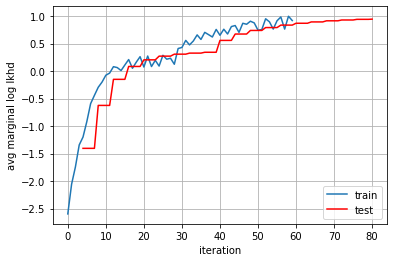

In [35]:
num_batches = 4
batched_emissions = jnp.split(emissions, num_batches, axis=0)
print(f'num_batches: {len(batched_emissions)}, minibatch shape: {batched_emissions[0].shape}')

test_hmm = GaussianHMM.random_initialization(jr.PRNGKey(2), num_states, emission_dim)

fitted_hmm, train_lls, vldtn_lls, posteriors, vldtn_posterior = \
    hmm_stochastic_em(seed=jr.PRNGKey(3),
                      train_dataset=batched_emissions[:-1],
                      validation_dataset=batched_emissions[-1],
                      hmm=test_hmm,
                      num_epochs=20)
# ------------------------------------------------------------------------------                      
vldtn_lls = jnp.concatenate([jnp.array([jnp.nan]), vldtn_lls])
vldtn_lls = jnp.concatenate([
    jnp.repeat(vldtn_lls[:-1], len(batched_emissions)), jnp.array([vldtn_lls[-1] ] )])

plt.plot(train_lls, label="train")
plt.plot(vldtn_lls, '-r', label="test")
plt.xlabel("iteration")
plt.ylabel("avg marginal log lkhd")
plt.grid(True)
plt.legend(loc="lower right")

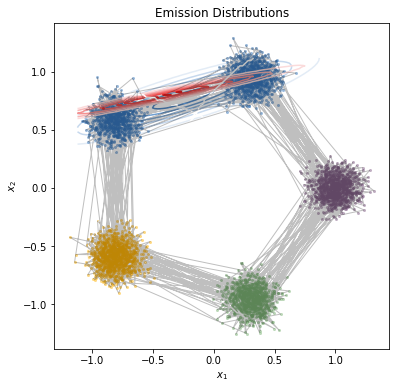

In [36]:
most_likely_states = fitted_hmm.most_likely_states(emissions)
plot_gaussian_hmm(fitted_hmm, emissions, most_likely_states)

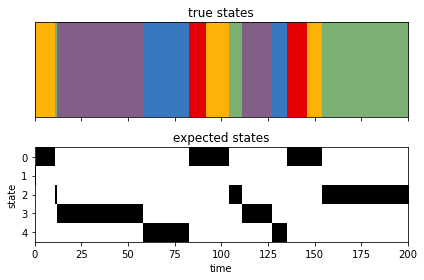

In [38]:
# TODO: Ideally, make white background in expected states transparent
# Then, display true states (in color) with black ticks of expected states on top
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(true_states[None,:],
              aspect="auto",
              interpolation="none",
              cmap=cmap, 
              vmin=0, vmax=len(colors)-1,
              alpha=1)
axs[0].set_yticks([])
axs[0].set_title("true states")

axs[1].imshow(posteriors[0].smoothed_probs.T,
              aspect="auto",
              interpolation="none",
              cmap="Greys",
              vmin=0, vmax=1)
axs[1].set_yticks(jnp.arange(fitted_hmm.num_states))
axs[1].set_ylabel("state")
axs[1].set_xlabel("time")
axs[1].set_title("expected states")

plt.xlim(0, 200)
plt.tight_layout()

In [62]:
dir(test_hmm)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_emission_distribution',
 '_initial_distribution',
 '_transition_distribution',
 'emission_covariance_matrices',
 'emission_distribution',
 'emission_means',
 'emission_shape',
 'filter',
 'from_unconstrained_params',
 'hyperparams',
 'initial_distribution',
 'initial_probabilities',
 'log_prob',
 'm_step',
 'marginal_log_prob',
 'most_likely_states',
 'num_obs',
 'num_states',
 'random_initialization',
 'sample',
 'smoother',
 'transition_distribution',
 'transition_matrix',
 'tree_flatten',
 'tree_unflatten',
 'unconstrained_params']